# Variational Autoencoders

### The Dream Weaver and the Mapmaker

<img src="./images/mapmaker and dreamweaver.webp" alt="mapmaker and dreamweaver" width=500>

In a faraway kingdom, there lived a Dream Weaver, known for creating vivid dreams from the countless experiences and thoughts of the people. However, the dreams were chaotic and abstract, often leaving the dreamers confused. They sought clarity, so the Dream Weaver set out on a quest to find a way to distill these scattered dreams into something meaningful and beautiful.

One day, she met a wise Mapmaker who carried a magical map. This map was unique: it did not show every detail of the kingdom but captured its essential shape and structure, enabling anyone to easily navigate the land without being overwhelmed by complexity.

Seeing the potential, the Dream Weaver and the Mapmaker formed an alliance. Their plan was simple: reduce the complexity of dreams to their essence (like a map), and then, using that essence, recreate dreams that were both vivid and coherent. Here's how their partnership worked.

### Step 1: The Mapmaker's Magic (Encoding)

<img src="./images/mapmaker-encoding.webp" alt="mapmaker encoding" width=500>

The Mapmaker, with his magical map, helped the Dream Weaver compress the dreams. He didn't need to capture every detail of the dream — just enough to maintain its essence. For every chaotic and detailed dream that came their way, the Mapmaker used his enchanted tools to encode the dream into a simple, structured map of possibilities. This map was smaller and more manageable, yet it carried all the important features of the dream, much like turning a vast, complicated landscape into a simplified but accurate map.

### Step 2: The Dream Weaver's Art (Decoding)

<img src="./images/dream weaver-decoding.webp" alt="dream weaver decoding" width=500>

Next, the Dream Weaver took the simplified map from the Mapmaker and worked her magic. Using the essence captured on the map, she recreated the dream. She didn’t just recreate it exactly, but instead wove new dreams from the structure and essence of the old ones. These new dreams were similar to the originals, but they were clearer and more harmonious, as if they had been purified and transformed through the Mapmaker’s process.

### Step 3: The Cycle of Learning

<img src="./images/mapmaker and dream weaver-training.webp" alt="mapmaker and dream weaver training" width=500>

At first, the dreams the Dream Weaver recreated weren’t perfect. Some details were off, and some dreams were too simple or too random. But the Dream Weaver and the Mapmaker weren’t discouraged. Every time they made a mistake, they studied it, learning from the flaws. The Mapmaker refined his tools to make better maps, and the Dream Weaver honed her skills to generate clearer dreams. Over time, they became better and better at capturing the right essence and recreating beautiful, meaningful dreams.

### The Magic Behind the Scenes

<img src="./images/magic behind the scenes.webp" alt="magic behind the scenes" width=500>

Unbeknownst to most, the Mapmaker and the Dream Weaver had a secret: they weren’t just drawing simple maps; they were working with probabilities. Each map wasn’t a fixed, rigid representation of the dream, but rather a range of possibilities, a landscape of potential dreams. When the Dream Weaver worked her magic, she could randomly pick from this range of possibilities, leading to slightly different dreams each time. This made the process creative and allowed her to explore countless variations of a single dream.

### The Kingdom's Harmony

<img src="./images/kingdoms harmony-generation.webp" alt="kingdoms harmony" width=500>

Through this magical collaboration, the kingdom's people no longer experienced fragmented, chaotic dreams. Instead, they dreamed in a way that was both imaginative and understandable. The Dream Weaver, with the help of the Mapmaker’s structured maps, gave everyone not just random dreams, but meaningful ones, born from the interplay of possibility and essence.

## Autoencoders

The story illustrates how autoencoders work.

### The Metaphor

- The Mapmaker symbolizes the encoder, which compresses the original data (dreams) into a smaller, latent representation (map).

- The Dream Weaver represents the decoder in a variational autoencoder (VAE), which generates new data (dreams) from a compressed, simplified version of the original data.

- The map is the compressed, simplified version of the original data, or latent space, which encodes the essential features of the data.

- The idea of refining the process over time corresponds to the learning process of the VAE, improving how well it encodes and decodes through training.

- The range of possibilities the Dream Weaver picks from represents the probabilistic nature of the latent space in VAEs, where the system generates variations by sampling from a distribution of possibilities.

# 👖 Autoencoders on Fashion MNIST

In this notebook, we'll walk through the steps required to train an autoencoder on the fashion MNIST dataset.

### The Fashion MNIST Dataset

This is a collection of grayscale images of clothing with each image only 28 x 28 pixels in size.

![mnist example](./images/mnist%20example.jpeg)

We will be padding each image out to 32 x 32 so they are easier to work with, and this dataset is available directly from Tensorflow, so we will be downloading it from there.

### Autoencoder Architecture

We will be building a simple autoencoder that contains the encoder that compresses high-dimensional input data into a lower-dimensional embedding vector (latent space) as well as a decoder that takes that embedding and decompresses it back to high-dimensional data.

![autoencoder architecture](./images/autoencoder%20architecture.jpeg)


In [1]:
# Loading the libraries we will need

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, datasets, callbacks

from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from utils import display



2024-10-04 09:41:53.433667: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 09:41:56.314204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# GPU
with tf.device('/GPU:0'):
    start = timer()
    model_cpu = get_model()
    model_cpu.fit(X_train_scaled, y_train_encoded, epochs = 1)
    end = timer()


print("GPU time: ", end - start)

## 0. Parameters <a name="parameters"></a>

In [2]:
# Model Parameters

IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 10
EPOCHS = 10


## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Load the data downloaded from Tensorflow

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
# Preprocess the data

def preprocess(imgs):
    '''
    Normalize and reshape images
    '''
    imgs = imgs.astype('float32') / 255.0
    # (1, 28, 28) --> (1, 32, 32) constant_values is black
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1) # creating a new axis in each image, so now is (1, 32, 32, 1)?
    
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)
#y_train = preprocess(y_train)
#y_test = preprocess(y_test)

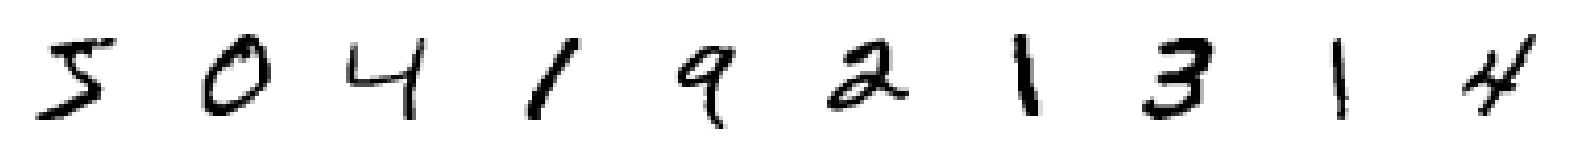

In [5]:
display(x_train)


## 2. Build the autoencoder <a name="build"></a>

### The Encoder

To encode the information to the latent space, we will be using the following model:

|Layer (type)|Output Shape|Param #|
|:----|:----:|----:|
|Input Layer|(None, 32, 32, 1)|0|
|Conv2D|(None, 16, 16, 32)|320|
|Conv2D|(None, 8, 8, 64)|18,496|
|Conv2D|(None, 4, 4, 128)|73,856|
|Flatten|(None, 2048)|0|
|Dense|(None, 2)|4098|
||||
|Total params||96,770|
|Trainable params||96,770|
|Non-trainable params||0

In [6]:
# Encoder

encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name='encoder_input')

x = layers.Conv2D(32, (3, 3), strides=2, activation ='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name='encoder_output')(x)
encoder = models.Model(encoder_input, encoder_output)
encoder.summary()


2024-10-04 09:42:05.222391: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 09:42:05.657204: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 09:42:05.661821: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

InternalError: cudaSetDevice() on GPU:0 failed. Status: out of memory

### The Decoder

For the decoder, we are going to mirror the encoder. The counter to Conv2D is the Conv2DTranspose.

|Layer (type)|Output Shape|Param #|
|:----|:----:|----:|
|Input Layer|(None, 2)|0|
|Dense|(None, 2048)|6144|
|Reshape|(None, 4, 4, 128)|0|
|Conv2DTranspose|(None, 8, 8, 128)|147,584|
|Conv2DTranspose|(None, 16, 16, 64)|73,792|
|Conv2DTranspose|(None, 32, 32, 32)|18,464|
|Conv2D|(None, 32, 32, 1)|289|
||||
|Total params||246,273|
|Trainable params||246,273|
|Non-trainable params||0

In [8]:
# Decoder

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name='decoder_input')
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)

decoder_output = layers.Conv2D(CHANNELS, (3, 3), strides=1, activation='sigmoid', padding='same',
                               name='decoder_output')(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

### Putting It All Together

Now we need to join the encoder to the decoder. Keras makes this easy with Model class.

In [9]:
# Autoencoder

autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the autoencoder <a name="train"></a>

In [10]:
# Compile the autoencoder

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(filepath='./checkpoint.keras', 
                            save_weights_only=False, save_freq='epoch',
                            monitor='loss', mode='min', save_best_only=True, verbose=0)
tensorboard_callback = callbacks.TensorBoard(log_dir='./logs')


In [16]:
# Train the autoencoder
with tf.device('/GPU:0'):
    autoencoder.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, 
                validation_data=(x_test, x_test), 
                callbacks=[model_checkpoint_callback, tensorboard_callback])


2024-10-01 22:55:10.805591: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2024-10-01 22:55:13.327081: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2024-10-01 22:55:16.004523: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2024-10-01 22:55:16.696939: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1727841330.966862    6855 service.cc:145] XLA service 0x602f27614bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727841330.971065    6855 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-10-01 22:55:32.172826: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-01 22:55:35.520186: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1727841354.668069    6855 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


595/600 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2463

2024-10-01 22:56:10.707271: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.


600/600 ━━━━━━━━━━━━━━━━━━━━ 50s 33ms/step - loss: 0.2457 - val_loss: 0.1555
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.1539 - val_loss: 0.1476
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.1482 - val_loss: 0.1442
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1442 - val_loss: 0.1413
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.1415 - val_loss: 0.1414
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.1403 - val_loss: 0.1388
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.1385 - val_loss: 0.1384
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.1374 - val_loss: 0.1378
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1370 - val_loss: 0.1369
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1361 - val_loss: 0.1367


In [19]:
# Save the final models
autoencoder.save('./models/autoencoder.keras')
encoder.save('./models/encoder.keras')
decoder.save('./models/decoder.keras')

## 4. Reconstruct using the autoencoder <a name="reconstruct"></a>

In [20]:
# Reconstruct some images

n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]



157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Example real numbered items:


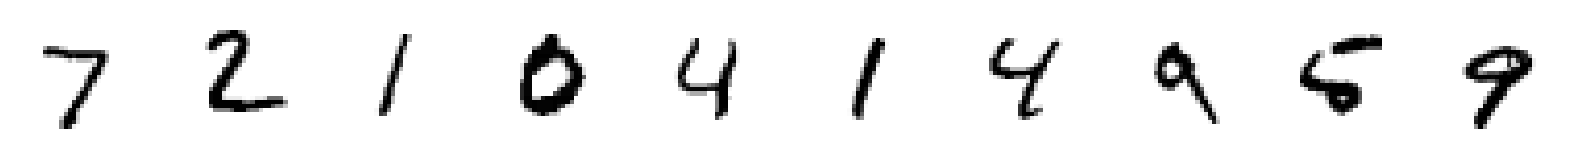

Reconstructions:


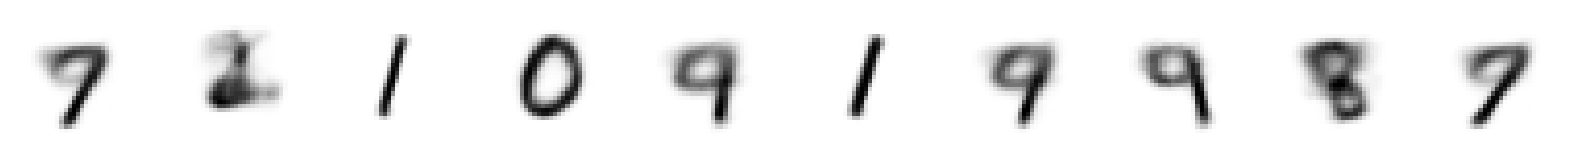

In [30]:
predictions = autoencoder.predict(example_images)
print('Example real numbered items:')
display(example_images)
print('Reconstructions:')
display(predictions)

## 5. Embed using the encoder <a name="encode"></a>

Let's see what the latent space looks like after the encoder embeds the input.

In [22]:
# Encode the example images
embeddings = encoder.predict(example_images)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [23]:
# Some examples of the embeddings
print(embeddings[:10])


[[ 0.10369462 -0.9027192 ]
 [-0.38160044  0.6199542 ]
 [ 0.83725    -4.643371  ]
 [-1.6396719   1.6722547 ]
 [ 0.68333226 -0.1600379 ]
 [ 0.5227478  -3.591375  ]
 [ 0.26602054 -0.522256  ]
 [ 1.9043297   0.10070885]
 [-0.01083295 -0.08458491]
 [-0.14783764 -1.0867062 ]]


Let's look at how the embeddings look in a 2D latent space.

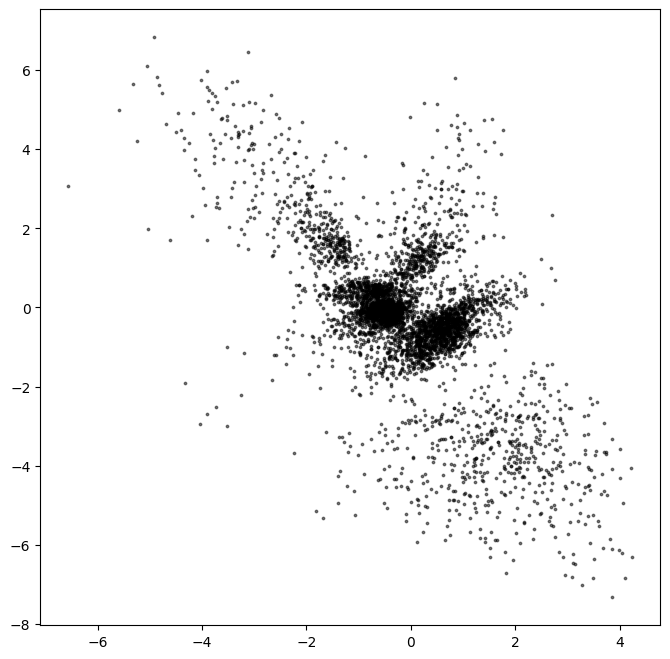

In [24]:
# Show the encoded points in 2D space
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=3)
plt.show()

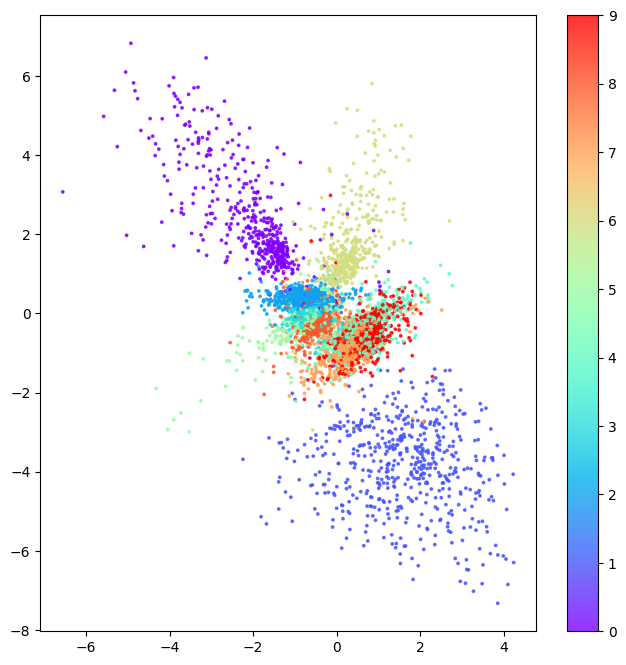

In [25]:
# Color the embeddings by their label (clothing type - see table)

example_labels = y_test[:n_to_predict]
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1],
           cmap='rainbow', c=example_labels, alpha = 0.8, s = 3)
plt.colorbar()
plt.show()


## 6. Generate using the decoder <a name="decode"></a>


In [26]:
# Get the range of the existing embeddings

mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

grid_width, grid_height = (6, 3)
sample = np.random.uniform(mins, maxs, size=(grid_width*grid_height, EMBEDDING_DIM))


In [1]:
# Decode the sampled points

reconstructions = decoder.predict(sample)
display(reconstructions[:10])

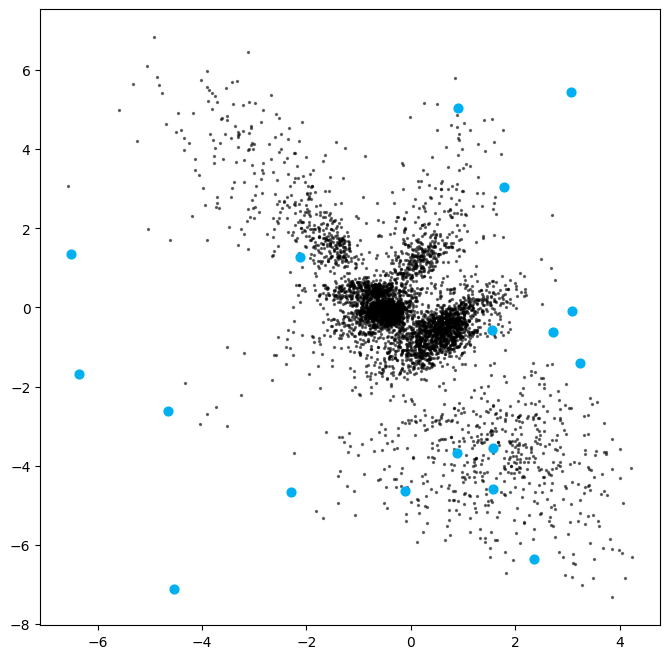

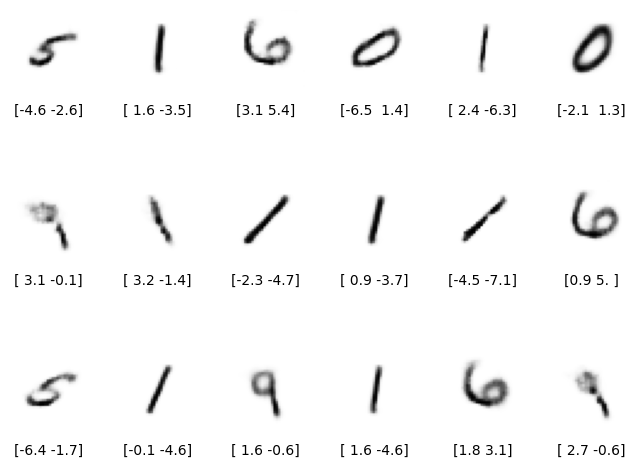

In [28]:
# Draw a plot of...

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(sample[:, 0], sample[:, 1], c='#00B0f0', alpha = 1, s=40)
plt.show()

fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(sample[i, :], 1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(reconstructions[i, :, :], cmap='Greys')


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


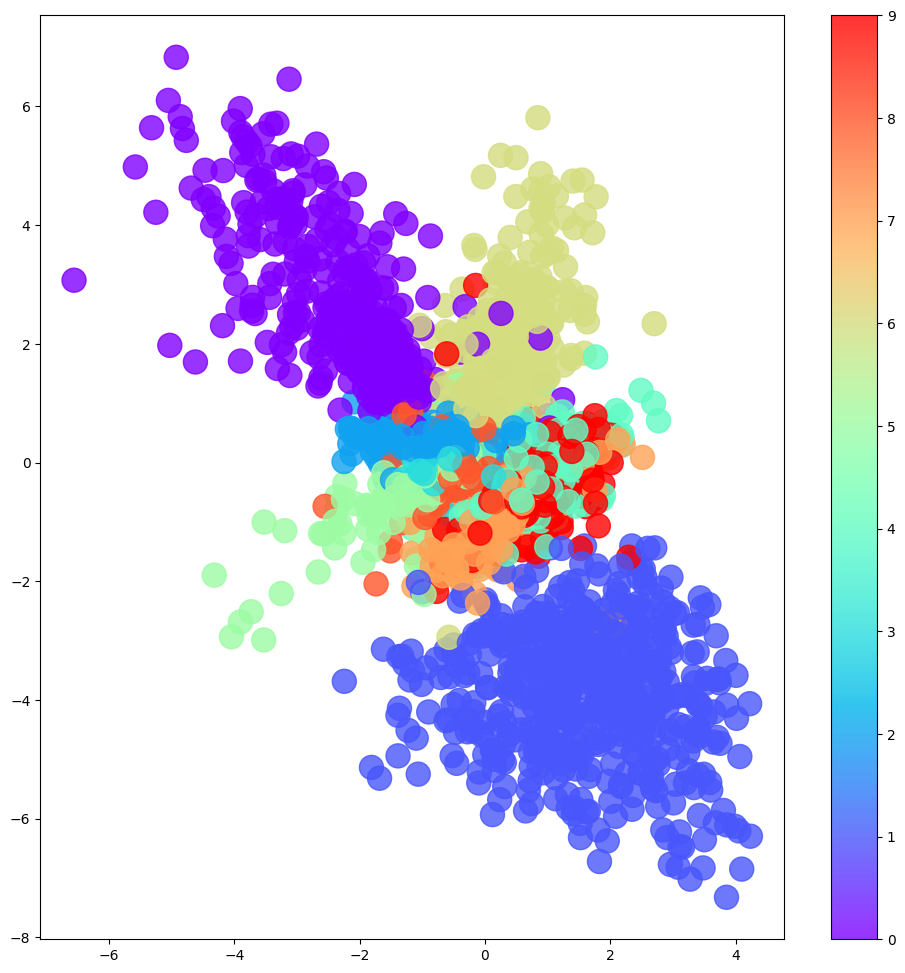

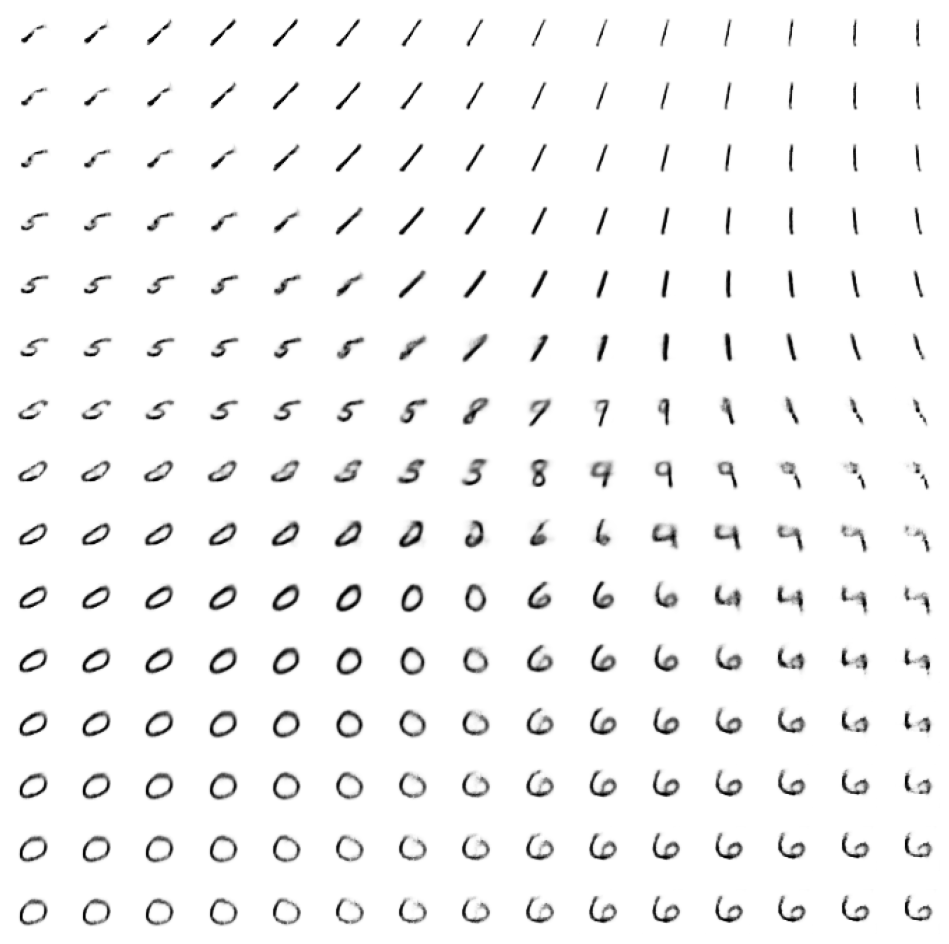

In [29]:
# Color the embeddings by their label (clothing type - see table)

figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1],
           cmap='rainbow', c=example_labels, alpha = 0.8, s = 300)
plt.colorbar()
x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(min(embeddings[:, 1]), max(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))
reconstructions = decoder.predict(grid)

plt.show()
fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconstructions[i, :, :], cmap='Greys')
    
    
